In [1]:
# Φόρτωση βιβλιοθηκών
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

C:\Users\chris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Ανάγνωση Δεδομένων
greece_inflation = pd.read_csv('Inflation and Parameters.csv')
greece_inflation.head()

,Date,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
0,2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
1,2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2,2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
3,2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
4,2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [3]:
# Επιλέγουμε τις απαραίτητες στήλες από το dataset
cols=['Date', 'Cpi']

inflation_parameters = greece_inflation.loc[:, greece_inflation.columns.intersection(cols)]
inflation_parameters.head()

,Date,Cpi
0,2001-01-01,0.001806
1,2001-02-01,0.000000
2,2001-03-01,0.036626
3,2001-04-01,0.054424
4,2001-05-01,0.062677


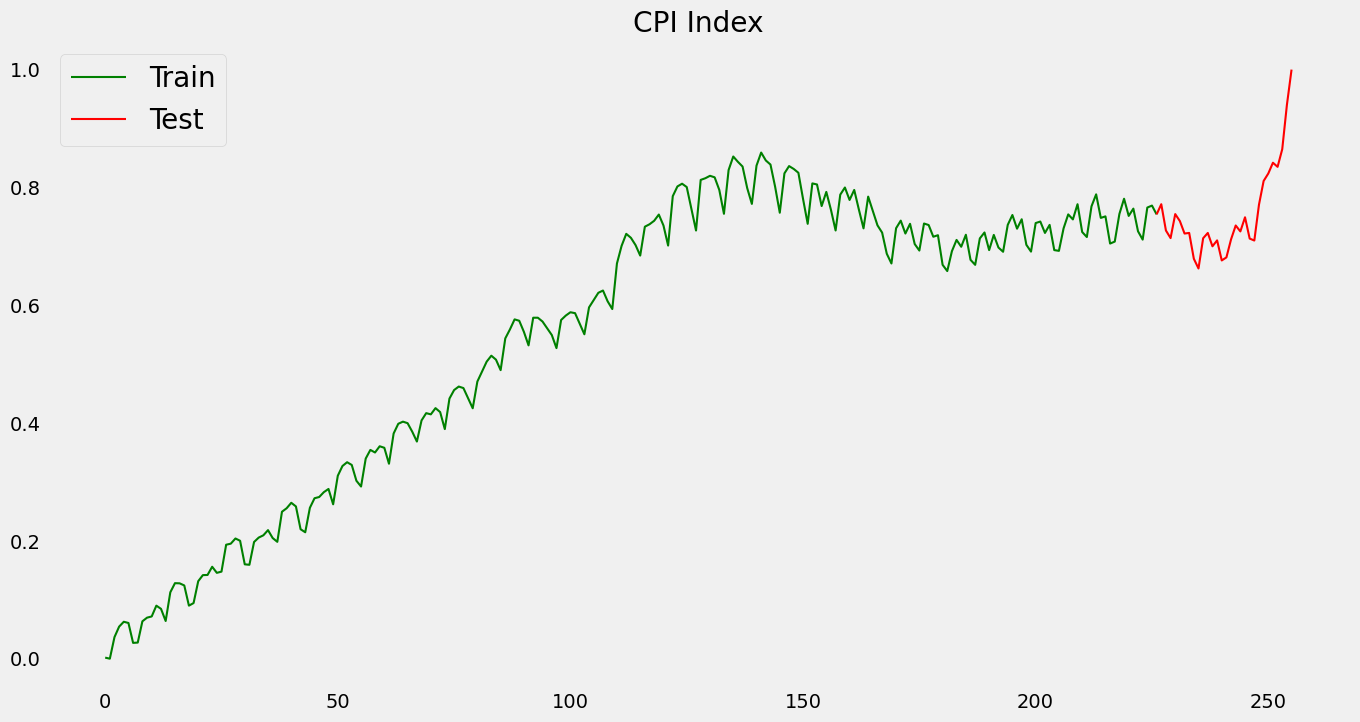

In [4]:
# Split δεδομένων σε train και test datasets. Εφαρμόζουμε το μοντέλο στους τελευταίους 30 μήνες των δεδομένων μας.
timestep = 30
train_df = greece_inflation.iloc[:len(greece_inflation)-timestep +1]
test_df = greece_inflation.iloc[len(greece_inflation)-timestep:]       # take the last timestep rows
train_df.Cpi.plot(figsize=(15,8), title= 'CPI Index', fontsize=14, label='Train', color = 'green')
test_df.Cpi.plot(figsize=(15,8), title= 'CPI Index', fontsize=14, label='Test', color='red')
plt.legend(fontsize = 20, loc='upper left')
plt.grid()
plt.show()

In [5]:
# Μετανομάζουμε την στήλη Cpi σε y, ώστε να εφαρμόσουμε το AutoSklearn forecasting μοντέλο
data = inflation_parameters
data = data.set_index('Date')
data = data.rename(columns={'Cpi': 'y'})
data = data.sort_index()
data.head()

,y
Date,
2001-01-01,0.001806
2001-02-01,0.000000
2001-03-01,0.036626
2001-04-01,0.054424
2001-05-01,0.062677


In [6]:
data.tail()

,y
Date,
2021-12-01,0.841888
2022-01-01,0.834924
2022-02-01,0.864844
2022-03-01,0.939902
2022-04-01,1.000000


In [7]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [8]:
data.index.max()

'2022-04-01'

In [9]:
data.shape[0]

256

In [10]:
# ορισμός των steps 
steps = timestep
data_train = data[:len(data)-steps+1]
data_test  = data[len(data)-steps:]

In [11]:
# train του μοντέλου Random Forest Regressor για την πρόβλεψη της χρονοσειράς
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6)
forecaster.fit(y = data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 226] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-15 14:04:39 
Last fit date: 2023-01-15 14:04:39 
Skforecast version: 0.4.3 

In [12]:
# εφαρμογή του μοντέλου για steps πλήθος προβλέψεων
predictions = forecaster.predict(steps=steps).to_frame()
predictions

,pred
227,0.753781
228,0.725099
229,0.713975
230,0.751757
231,0.751620
232,0.747434
233,0.754029
234,0.740199
235,0.725352
236,0.755133


In [13]:
# προσθήκη των predictions στο test dataset, με σκοπό τον υπολογισμό των error metrics
data_test['predictions'] = predictions.to_numpy()

In [14]:
data_test

,y,predictions
Date,,
2019-11-01,0.754191,0.753781
2019-12-01,0.771473,0.725099
2020-01-01,0.726851,0.713975
2020-02-01,0.713954,0.751757
2020-03-01,0.754707,0.751620
2020-04-01,0.742842,0.747434
2020-05-01,0.721692,0.754029
2020-06-01,0.722724,0.740199
2020-07-01,0.678875,0.725352


In [15]:
# Υπολογισμός του MAE
from sklearn.metrics import mean_absolute_error
mae_value = mean_absolute_error(data_test['y'], data_test['predictions'])
print(f'MAE value: {mae_value}')

MAE value: 0.05405175823231017


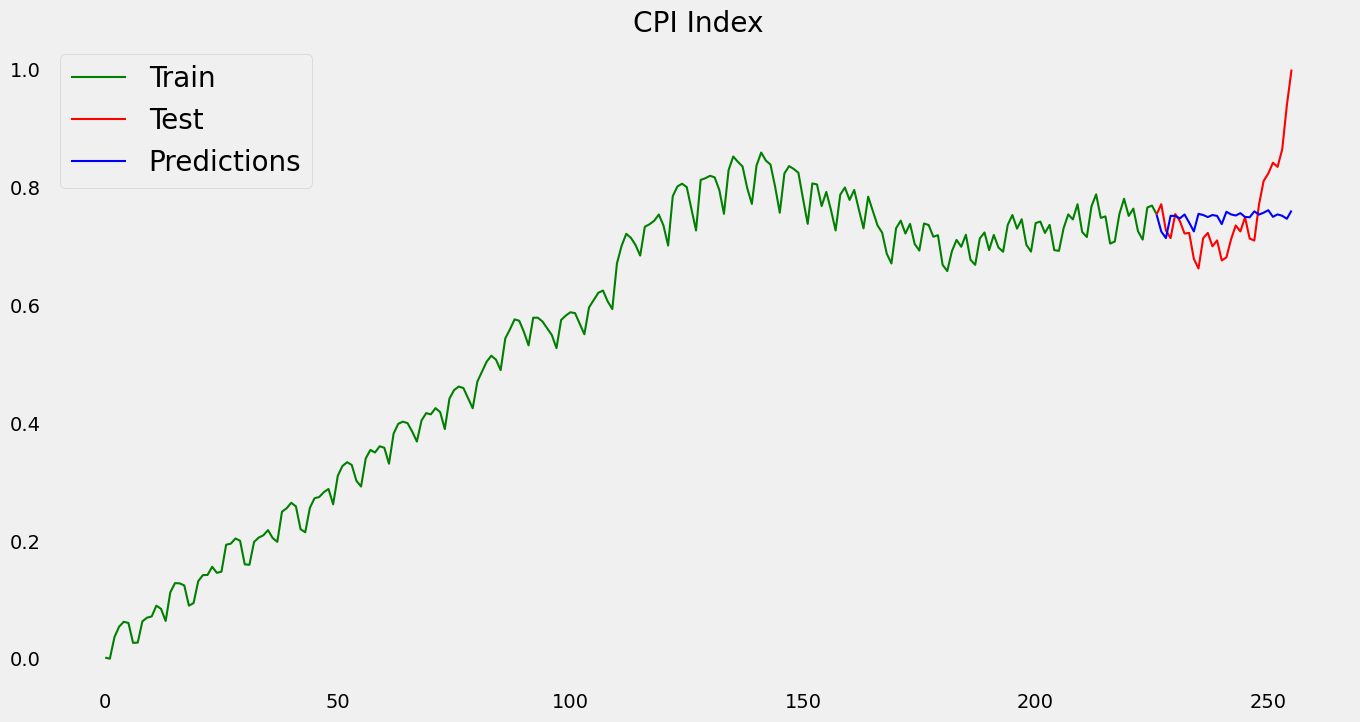

In [16]:
# Σχεδιασμός διαγράμματος
train_df = greece_inflation.iloc[:len(greece_inflation)-timestep +1]
test_df = greece_inflation.iloc[len(greece_inflation)-timestep:]       # take the last timestep rows
test_df['predictions'] = predictions.to_numpy()
train_df.Cpi.plot(figsize=(15,8), title= 'CPI Index', fontsize=14, label='Train', color = 'green')
test_df.Cpi.plot(figsize=(15,8), title= 'CPI Index', fontsize=14, label='Test', color='red')
test_df.predictions.plot(figsize=(15,8), title= 'CPI Index', fontsize=14, label='Predictions', color='blue')
plt.legend(fontsize = 20, loc='upper left')
plt.grid()
plt.show()